In [472]:
import sys
import os
sys.path.append(os.path.abspath('../'))

import optuna
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score
from xgboost import XGBClassifier


In [473]:
from src import Root
root = Root()
root.lib.jupyter_settings()

In [474]:
df = pd.read_csv("../data/housing_resampled.csv")

In [475]:
df['high_value'] = (df['target'] >= 500000).astype(int)
df_backup = df.copy()

In [476]:
print(f"Class distribution:\n{df['high_value'].value_counts()}")
print(f"Percentage of high-value houses: {df['high_value'].mean() * 100:.2f}%")

Class distribution:
high_value
0    20143
1      992
Name: count, dtype: int64
Percentage of high-value houses: 4.69%


In [477]:
df.isna().mean()

longitude                                 0.00
latitude                                  0.00
housing_median_age                        0.00
total_rooms                               0.00
total_bedrooms                            0.00
population                                0.00
households                                0.00
median_income                             0.00
target                                    0.00
total_rooms_per_households                0.00
total_bedrooms_per_households             0.00
income_per_household                      0.00
total_rooms_not_bedrooms                  0.00
population_per_hosehold                   0.00
income_per_population                     0.00
total_rooms_not_bedrooms_per_households   0.00
distance_to_los_angeles                   0.00
distance_to_san_francisco                 0.00
distance_to_san_diego                     0.00
distance_to_sacramento                    0.00
distance_to_silicon_valley                0.00
distance_to_f

In [478]:
df.sample(15)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,target,total_rooms_per_households,total_bedrooms_per_households,income_per_household,total_rooms_not_bedrooms,population_per_hosehold,income_per_population,total_rooms_not_bedrooms_per_households,distance_to_los_angeles,distance_to_san_francisco,distance_to_san_diego,distance_to_sacramento,distance_to_silicon_valley,distance_to_fresno,distance_to_santa_barbara,distance_to_san_jose,distance_to_oakland,distance_to_anaheim,distance_to_golden_gate_bridge,distance_to_yosemite_valley,distance_to_death_valley,distance_to_big_sur,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN,high_value
8510,-118.31,33.88,21.00,1490.00,430.00,686.00,400.00,2.38,237500.00,3.73,1.07,0.01,1060.00,1.72,0.00,2.65,12.49,354.06,104.28,370.10,320.90,214.29,87.73,312.11,350.27,22.90,358.52,283.79,199.07,257.65,False,False,False,False,0
17614,-121.92,37.29,32.00,1260.00,199.00,560.00,207.00,6.59,346700.00,6.09,0.96,0.03,1061.00,2.71,0.01,5.13,304.29,43.26,415.12,92.21,10.12,123.70,234.03,3.81,40.41,327.99,47.70,136.33,280.43,70.72,False,False,False,False,0
183,-122.23,37.80,50.00,1746.00,480.00,1149.00,415.00,2.25,123500.00,4.21,1.16,0.01,1266.00,2.77,0.00,3.05,341.68,10.49,452.81,67.17,30.02,153.06,272.89,37.05,2.26,365.22,13.62,146.95,304.49,108.22,False,False,True,False,0
15967,-122.40,37.72,40.00,1948.00,413.00,1434.00,396.00,3.03,219100.00,4.92,1.04,0.01,1535.00,3.62,0.00,3.88,343.95,3.94,454.80,77.23,29.66,158.95,273.34,38.58,9.14,367.62,8.12,156.56,312.12,105.35,False,False,True,False,0
7057,-118.04,33.93,35.00,1805.00,387.00,1505.00,366.00,4.17,151900.00,4.93,1.06,0.01,1418.00,4.11,0.00,3.87,14.40,361.46,98.05,374.54,328.46,217.55,100.67,319.48,357.38,9.68,365.93,284.52,190.35,267.39,False,False,False,False,0
1853,-124.21,41.77,17.00,3461.00,722.00,1947.00,647.00,2.58,68400.00,5.35,1.12,0.00,2739.00,3.01,0.00,4.23,624.22,291.93,735.37,262.80,323.74,420.44,563.72,330.25,292.67,646.54,287.97,366.30,531.62,401.22,False,False,False,True,0
1917,-120.72,38.94,10.00,1604.00,352.00,540.00,190.00,3.76,113200.00,8.44,1.85,0.02,1252.00,2.84,0.01,6.59,364.61,122.30,473.91,48.52,129.56,160.44,317.33,127.53,114.96,385.54,122.71,98.03,265.48,193.82,True,False,False,False,0
5112,-118.29,33.97,48.00,3139.00,587.00,1319.00,506.00,3.52,134200.00,6.20,1.16,0.01,2552.00,2.61,0.00,5.04,6.27,350.01,108.43,365.15,316.90,209.01,86.29,308.04,346.12,23.43,354.47,278.03,192.89,254.51,False,False,False,False,0
9095,-118.32,34.62,31.00,1398.00,273.00,884.00,299.00,4.84,264900.00,4.68,0.91,0.02,1125.00,2.96,0.01,3.76,39.47,315.78,147.49,325.41,283.16,167.90,79.66,273.88,311.26,58.88,320.26,234.26,153.41,227.02,True,False,False,False,0
17766,-121.85,37.34,27.00,1481.00,409.00,1505.00,391.00,2.58,137500.00,3.79,1.05,0.01,1072.00,3.85,0.00,2.74,304.17,43.31,415.16,87.95,11.86,121.14,234.91,2.00,39.51,327.80,47.78,131.64,277.22,73.94,False,False,False,False,0


In [479]:
df.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income', 'target',
       'total_rooms_per_households', 'total_bedrooms_per_households',
       'income_per_household', 'total_rooms_not_bedrooms',
       'population_per_hosehold', 'income_per_population',
       'total_rooms_not_bedrooms_per_households', 'distance_to_los_angeles',
       'distance_to_san_francisco', 'distance_to_san_diego',
       'distance_to_sacramento', 'distance_to_silicon_valley',
       'distance_to_fresno', 'distance_to_santa_barbara',
       'distance_to_san_jose', 'distance_to_oakland', 'distance_to_anaheim',
       'distance_to_golden_gate_bridge', 'distance_to_yosemite_valley',
       'distance_to_death_valley', 'distance_to_big_sur',
       'ocean_proximity_INLAND', 'ocean_proximity_ISLAND',
       'ocean_proximity_NEAR BAY', 'ocean_proximity_NEAR OCEAN', 'high_value'],
      dtype='object')

In [480]:
features = [
'longitude', 
'latitude', 
'housing_median_age', 
'total_rooms',
'total_bedrooms', 
'population', 
'households', 
'median_income', 
# 'target',
'total_rooms_per_households', 
'total_bedrooms_per_households',
'income_per_household', 
'total_rooms_not_bedrooms',
'population_per_hosehold', 
'income_per_population',
'total_rooms_not_bedrooms_per_households', 
'distance_to_los_angeles',
'distance_to_san_francisco', 
'distance_to_san_diego',
'distance_to_sacramento', 
'distance_to_silicon_valley',
'distance_to_fresno', 
'distance_to_santa_barbara',
'distance_to_san_jose', 
'distance_to_oakland', 
'distance_to_anaheim',
'distance_to_golden_gate_bridge', 
'distance_to_yosemite_valley',
'distance_to_death_valley', 
'distance_to_big_sur',
'ocean_proximity_INLAND', 
'ocean_proximity_ISLAND',
'ocean_proximity_NEAR BAY', 
'ocean_proximity_NEAR OCEAN', 
# 'high_value'
]

In [481]:
X = df[features]
y = df['high_value']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [482]:
rf_clf = XGBClassifier(
    max_depth = 6,
    # gamma = 0.1,
    # alpha = 0.1,
    n_estimators=100, 
    random_state=42, 
    eval_metric='logloss'
)
rf_clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [483]:
y_pred = rf_clf.predict(X_test)

print("Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Results:
Accuracy: 0.9778

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      4029
           1       0.83      0.66      0.74       198

    accuracy                           0.98      4227
   macro avg       0.91      0.83      0.86      4227
weighted avg       0.98      0.98      0.98      4227




Confusion Matrix:


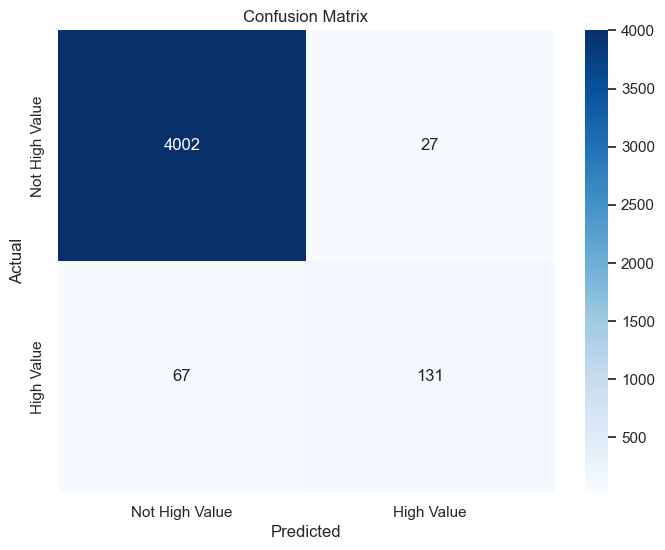

In [484]:
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not High Value', 'High Value'],
            yticklabels=['Not High Value', 'High Value'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


Feature Importance:
                           Feature  Importance
7                    median_income        0.20
25  distance_to_golden_gate_bridge        0.12
29          ocean_proximity_INLAND        0.11
2               housing_median_age        0.05
18          distance_to_sacramento        0.05
12         population_per_hosehold        0.04
1                         latitude        0.03
21       distance_to_santa_barbara        0.03
26     distance_to_yosemite_valley        0.02
32      ocean_proximity_NEAR OCEAN        0.02


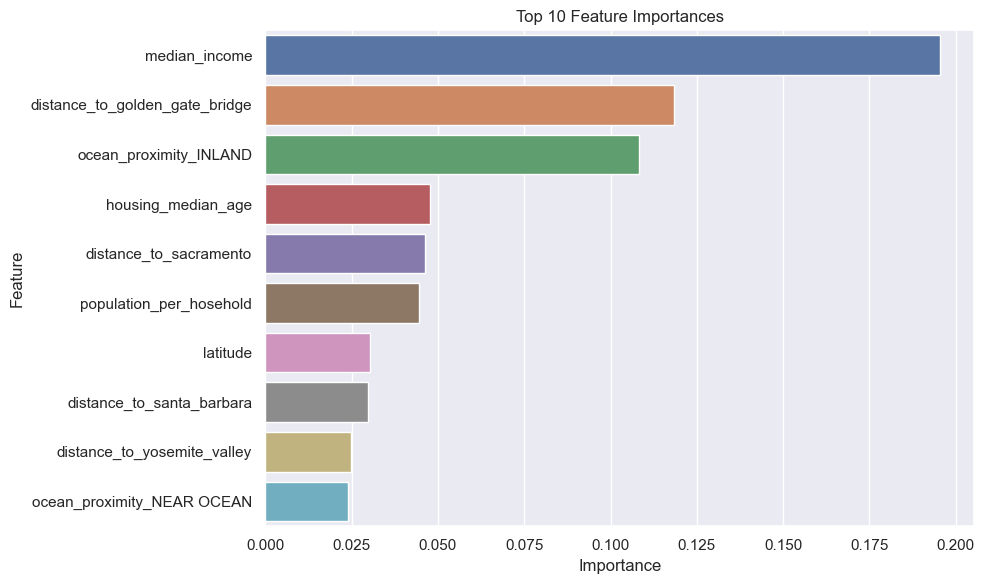

In [485]:
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': rf_clf.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance.head(10))

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10))
plt.title('Top 10 Feature Importances')
plt.tight_layout()
plt.show()


In [486]:
def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'alpha': trial.suggest_float('alpha', 0, 1.0),
        'lambda': trial.suggest_float('lambda', 0, 1.0),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 10)  # Important for recall
    }
    
    clf = XGBClassifier(
        **param,
        random_state=42,
        eval_metric='logloss',
        use_label_encoder=False  # Prevent warning
    )
    
    # cross-validation with recall 
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring='recall')
    
    return np.mean(scores)

study = optuna.create_study(direction='maximize')  # maximize recall (find all high value property -> will get predict_proba as a feature later)
study.optimize(objective, n_trials=100)  

print("Best trial:")
trial = study.best_trial
print(f"  Value (Recall): {trial.value:.4f}")

[I 2025-04-25 17:30:10,436] A new study created in memory with name: no-name-f2a87ed5-6b91-4361-b8d8-315be5012f57


c:\Users\joao.freitas\AppData\Local\anaconda3\envs\housing\lib\site-packages\xgboost\training.py:183: UserWarning: [17:30:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\joao.freitas\AppData\Local\anaconda3\envs\housing\lib\site-packages\xgboost\training.py:183: UserWarning: [17:30:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\joao.freitas\AppData\Local\anaconda3\envs\housing\lib\site-packages\xgboost\training.py:183: UserWarning: [17:30:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\joao.freitas\AppData\Local\anaconda3\envs\housing\lib\site-packages\xgboost\training.py:183: UserWarning: [17:30:11] W

Best trial:
  Value (Recall): 0.8489


In [487]:
best_params

{'n_estimators': 288,
 'max_depth': 3,
 'learning_rate': 0.029888965293115535,
 'subsample': 0.8510396560043576,
 'colsample_bytree': 0.6008426066945933,
 'gamma': 4.760643960791606,
 'min_child_weight': 6,
 'alpha': 0.43705296245196096,
 'lambda': 0.7648407978938008,
 'scale_pos_weight': 9.803211048915681}

In [488]:
best_params = study.best_params
best_model = XGBClassifier(
    **best_params,
    random_state=42,
    eval_metric='logloss'
)

# Train on the full training set
best_model.fit(X_train, y_train)

# Evaluate on test set

y_pred = best_model.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      4029
           1       0.47      0.88      0.61       198

    accuracy                           0.95      4227
   macro avg       0.73      0.92      0.79      4227
weighted avg       0.97      0.95      0.96      4227


Confusion Matrix:
[[3831  198]
 [  23  175]]


In [489]:
result_df = X.copy()

result_df["is_high_value"] = best_model.predict_proba(X)[:, 1]
result_df["target"] = df_backup["target"]

In [490]:
result_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,total_rooms_per_households,total_bedrooms_per_households,income_per_household,total_rooms_not_bedrooms,population_per_hosehold,income_per_population,total_rooms_not_bedrooms_per_households,distance_to_los_angeles,distance_to_san_francisco,distance_to_san_diego,distance_to_sacramento,distance_to_silicon_valley,distance_to_fresno,distance_to_santa_barbara,distance_to_san_jose,distance_to_oakland,distance_to_anaheim,distance_to_golden_gate_bridge,distance_to_yosemite_valley,distance_to_death_valley,distance_to_big_sur,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN,is_high_value,target
0,-122.23,37.88,41.00,880.00,129.00,322.00,126.00,8.33,6.98,1.02,0.07,751.00,2.56,0.03,5.96,345.81,12.63,457.02,62.80,35.31,155.72,277.60,41.90,5.68,369.30,14.17,146.81,305.98,113.62,False,False,True,False,0.56,452600.00
1,-122.22,37.86,21.00,7099.00,1106.00,2401.00,1138.00,8.30,6.24,0.97,0.01,5993.00,2.11,0.00,5.27,344.42,12.37,455.61,63.54,33.84,154.56,276.13,40.42,4.75,367.91,14.36,146.28,305.08,112.15,False,False,True,False,0.25,358500.00
2,-122.24,37.85,52.00,1467.00,190.00,496.00,177.00,7.26,8.29,1.07,0.04,1277.00,2.80,0.01,7.21,344.62,11.08,455.79,64.76,33.48,155.18,276.11,40.32,3.58,368.13,13.17,147.38,305.94,111.71,False,False,True,False,0.44,352100.00
3,-122.25,37.85,52.00,1274.00,235.00,558.00,219.00,5.64,5.82,1.07,0.03,1039.00,2.55,0.01,4.74,344.98,10.60,456.15,65.10,33.65,155.66,276.40,40.58,3.35,368.50,12.63,147.93,306.46,111.83,False,False,True,False,0.07,341300.00
4,-122.25,37.85,52.00,1627.00,280.00,565.00,259.00,3.85,6.28,1.08,0.01,1347.00,2.18,0.01,5.20,344.98,10.60,456.15,65.10,33.65,155.66,276.40,40.58,3.35,368.50,12.63,147.93,306.46,111.83,False,False,True,False,0.06,342200.00


In [491]:
result_df.query("target >= 500000")["is_high_value"].median() #0.85423213

0.916342

In [492]:
result_df.query("target < 500000")["is_high_value"].median() #0.85423213

0.010597113

In [493]:
(
    result_df
    .to_csv("../data/housing_labeled.csv",  index=False)
)